# Project 2 - Machine Learning, Fall 2022

Deadline: 11th of December 2022, 23:59

To do this project you have to complete this Jupyter notebook and send it via Discord.

The total number of points allocated for this project is 10.

You will need the following modules to solve the tasks:

In [1]:
import math
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from itertools import product

In [2]:
penguin_dataset = pd.read_csv("data/penguins_filtered.csv")

penguin_dataset = penguin_dataset.replace({
    "Adelie": 1,
    "Chinstrap" : 2,
    "Gentoo": 3,
    "male" : 0,
    "female" : 1,
    "Biscoe" : 0,
    "Dream" : 1,
    "Torgersen" : 2})

discrete_penguin_dataset = penguin_dataset[["sex", "island", "species"]]
print(penguin_dataset.head())
print(discrete_penguin_dataset.head())

   sex  island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
0    0       2            39.1           18.7              181.0       3750.0   
1    1       2            39.5           17.4              186.0       3800.0   
2    1       2            40.3           18.0              195.0       3250.0   
3    1       2            36.7           19.3              193.0       3450.0   
4    0       2            39.3           20.6              190.0       3650.0   

   species  
0        1  
1        1  
2        1  
3        1  
4        1  
   sex  island  species
0    0       2        1
1    1       2        1
2    1       2        1
3    1       2        1
4    0       2        1


## I. Naive and Joint Bayes (3.5 points; 0.15 bonus per week)

*Note*: Be careful at what Naive Bayes class you use from `sklearn`.

1. Calculate the prior probabilities for the target feature. Transform them by applying the natural logarithm. 

In [3]:
# solution here
def prior_probability_target(dataset, target):
    prob = [ list(dataset[target]).count(val) / len(dataset[target]) for val in np.unique(dataset[target])]
    prob = list(map(lambda x: math.log(x), prob))
    return prob

prior_probability_target(penguin_dataset, 'species')

[-0.8245358682721073, -1.5886347848043372, -1.0290189968689145]

2. Write the formulas used to calculate the maximum aposteriori probability using Naive Bayes and Joint Bayes. Use the names of the variables from the discrete penguin dataset.

*Answer here*:

3. Find and calculate the logarithm of all the conditional probabilities (also names likelihoods) used to predict the label for the instance `{"sex" : 1, "island" : 2}` in Naive Bayes.

In [4]:
# solution here
def likelihoods(dataset, target, sex_value, island_value):
    probabilities = list()

    for species_value in np.unique(dataset[target]):
        ds = dataset[dataset[target] == species_value].reset_index(drop=True)

        sex_count = list(ds['sex']).count(sex_value)
        island_count = list(ds['island']).count(island_value)
        species_count = list(dataset[target]).count(species_value)

        probabilities.append([np.log(sex_count/species_count), np.log(island_count/species_count)])
    
    return probabilities

likelihoods(discrete_penguin_dataset, 'species', 1, 2)

C:\Users\aiaco\AppData\Local\Temp\ipykernel_10448\3861210417.py:12: RuntimeWarning: divide by zero encountered in log
  probabilities.append([np.log(sex_count/species_count), np.log(island_count/species_count)])


[[-0.6931471805599453, -1.133459019998278],
 [-0.6931471805599453, -inf],
 [-0.7186804825651101, -inf]]

4. Why does the results contain infinity? Fix the calculation by using the Laplace Smoothing with `alpha = 1`.

In [5]:
# solution here
def likelihoods_laplace(dataset, target, sex_value, island_value, alpha = 1):
    probabilities = list()

    for species_value in np.unique(dataset[target]):
        ds = dataset[dataset[target] == species_value].reset_index(drop=True)

        sex_count = list(ds['sex']).count(sex_value) + alpha
        island_count = list(ds['island']).count(island_value) + alpha
        species_count = len(ds['species'])

        probabilities.append ([math.log(sex_count    / (species_count + alpha*len(np.unique(dataset['sex'])))),
                               math.log(island_count / (species_count + alpha*len(np.unique(dataset['island']))))] )
    return probabilities

likelihoods_laplace(discrete_penguin_dataset, 'species', 1, 2)

[[-0.6931471805599453, -1.1327452950375683],
 [-0.6931471805599453, -4.2626798770413155],
 [-0.7182531016910216, -4.804021044733257]]

5. Calculate the aposteriori probabilities of the labels and decide which label will Naive Bayes predict for the instance. Use only the logarithm values.

In [6]:
# solution here
def aposteriori(dataset, target, sex_value, island_value):
    priori = prior_probability_target(dataset, target)
    likelihood = likelihoods_laplace(dataset, target, sex_value, island_value)
    
    prod = list()
    for index in range(len(priori)):
        prod.append( (index + 1, math.exp(sum(likelihood[index], priori[index])) ) )

    suma = 0
    for index in range(len(prod)):
        suma += prod[index][1]

    prod = list(map(lambda x: x[1]/suma, prod))
    for index in range(3):
        prod[index] = (index+1, prod[index])
    return prod
    
aposteriori(discrete_penguin_dataset, 'species', 1 , 2)

[(1, 0.9609956286737821), (2, 0.019568798053176163), (3, 0.01943557327304175)]

6. **Naive Bayes implemenation**: write a function called `naive_bayes` that takes three arguments:
- `df`: the dataframe which will be used for training
- `index_target`: the index of the column associated with the target feature
- `alpha`: the parameter used for Laplace Smoothing

The function should return a dictionary with the following fields:
- `log_prior`: the logarithmic values of the prior probabilities (the probability of the labels)
- `log_likelihoods`: a n x m x t array, where n - the number of features; m - the number of labels; t - the number of values for a feature; this array will contain the logarithmic values of the likelihoods (P(feature = value | target_feature = label))
- `n_classes`: the number of labels
- `n_feature_classes`: a vector that contains the number of unique values for each attribute
- `classes`: the name of the labels (the values of the target feature).

In [7]:
def naive_bayes(df, index_target = -1, alpha = 1):
    target = df.columns[index_target]
    output = dict()
    output['log_prior'] = prior_probability_target(df, target)
    output['n_classes'] = list(np.unique(df[target]))
    output['n_feature_classes'] = [ list(np.unique(df[col])) for col in df.columns[:-1] ]
    output['classes'] = len(np.unique(df[target]))
    
    sex_list = dict()
    for sex in output['n_feature_classes'][0]:
        prob = likelihoods_laplace(df, target, sex, 0, alpha)
        sex_list[sex] = {1: prob[0][0], 2: prob[1][0], 3: prob[2][0]}

    island_list = dict()
    for island in output['n_feature_classes'][1]:
        prob = likelihoods_laplace(df, target, 0, island, alpha)
        island_list[island] = {1: prob[0][1], 2: prob[1][1], 3: prob[2][1]}

    
    output['log_likelihoods'] = {'sex': sex_list, 'island': island_list}
    return output

pprint(naive_bayes(discrete_penguin_dataset))

{'classes': 3,
 'log_likelihoods': {'island': {0: {1: -1.1972838161751393,
                                    2: -4.2626798770413155,
                                    3: -0.016529301951210582},
                                1: {1: -0.9785946152103099,
                                    2: -0.028573372444056,
                                    3: -4.804021044733257},
                                2: {1: -1.1327452950375683,
                                    2: -4.2626798770413155,
                                    3: -4.804021044733257}},
                     'sex': {0: {1: -0.6931471805599453,
                                 2: -0.6931471805599453,
                                 3: -0.6686561605516496},
                             1: {1: -0.6931471805599453,
                                 2: -0.6931471805599453,
                                 3: -0.7182531016910216}}},
 'log_prior': [-0.8245358682721073, -1.5886347848043372, -1.0290189968689145],
 'n_classes': [1,

7. Train the discrete penguin dataset using your version of Naive Bayes and sklearn's. Compare the values of the parameters.(Be careful at what type of Naive Bayes classifier you pick from sklearn!)

In [10]:
# solution here
from sklearn.naive_bayes import CategoricalNB

X = discrete_penguin_dataset[['sex','island']]
y = discrete_penguin_dataset['species']
cl = CategoricalNB(alpha=1).fit(X, y)

new_messages = pd.DataFrame(
  [(1, 2)],
columns = ['sex','island'])

pprint(cl.feature_log_prob_)
# print(cl.predict(new_messages), '\n', cl.predict_proba(new_messages))
#print(cl.predict_proba(new_messages))

[array([[-0.69314718, -0.69314718],
       [-0.69314718, -0.69314718],
       [-0.66865616, -0.7182531 ]]),
 array([[-1.19728382, -0.97859462, -1.1327453 ],
       [-4.26267988, -0.02857337, -4.26267988],
       [-0.0165293 , -4.80402104, -4.80402104]])]


8. Create a function named `nb_predict_prob` that uses the log probabilities calculated by Naive Bayes to infer the aposteriori probability of a new instance `X`.

In [10]:
def nb_predict_prob(nb_dict, X, use_log = False):
    prob = list()
    for trg in nb_dict['n_classes']:
        prb = nb_dict['log_prior'][trg-1] + nb_dict['log_likelihoods']['sex'][X[0]][trg] + nb_dict['log_likelihoods']['island'][X[1]][trg]
        prob.append(prb)

    return prob

nb_predict_prob(naive_bayes(discrete_penguin_dataset), [1,2], True)

[-2.6504283438696206, -6.544461842405598, -6.551293143293193]

9. Create a function that does the Naive Bayes prediction using the Maximum Aposteriori Probability.

In [11]:
def nb_predict(nb_dict, X):
    prob = nb_predict_prob(nb_dict, X)
    return prob.index(max(prob)) + 1

nb_predict(naive_bayes(discrete_penguin_dataset), [1,2])

1

10. Create a function that calculate the accuracy of the trained model on a set of instances `X` with known labels `y`.

In [12]:
def nb_score(nb_dict, X, y):
    ok = 0
    for index in range(len(X)):
        rez = nb_predict(nb_dict, list(X.loc[index]))
        if rez == y.loc[index]:
            ok += 1
    return ok

11. Calculate the training accuracy of your Naive Bayes algorithm. Explain the results.

In [13]:
# solution here
X = discrete_penguin_dataset[list(discrete_penguin_dataset.columns[:-1])]
y = discrete_penguin_dataset[discrete_penguin_dataset.columns[-1]]
nb_score(naive_bayes(discrete_penguin_dataset), X, y)/len(discrete_penguin_dataset)

0.7027027027027027

12. Find and calculate all the conditional probabilities (also names likelihoods) used to predict the label for the instance `{"sex" : 1, "island" : 2}` in Joint Bayes. (*Hint*: panda's query function might provide itself useful.)

In [14]:
# solution here
def jb_likelihoods(df, sex, island):
    cond_prob = list()
    for trg in np.unique(df['species']):
        filtered = df.query("species == @trg")
        likelihoods = filtered.query("sex == @sex and island == @island")
        cond_prob.append(len(likelihoods) / len(filtered))
    return cond_prob

jb_likelihoods(penguin_dataset, 1, 2)

[0.1643835616438356, 0.0, 0.0]

13. Calculate the aposteriori probabilities of the labels and decide which label will Joint Bayes predict for the instance. Use the conditional and prior probabilities (*not* the logarithmic values).

In [15]:
# solution here
def jb_aposteriori(df, sex, island):
    prior = prior_probability_target(df, 'species')
    prior = list(map(lambda x: math.exp(x), prior))
    likelihoods = jb_likelihoods(df, sex, island)

    aposteriori = list()
    for trg in np.unique(df['species']):
        aposteriori.append( prior[trg-1] * likelihoods[trg - 1] )

    # print(aposteriori)
    return aposteriori.index( max(aposteriori) ) + 1


jb_aposteriori(penguin_dataset, 1, 2)

1

14. **Joint Bayes implemenation**: write a function called `joint_bayes` that takes two arguments:
- `df`: the dataframe which will be used for training
- `index_target`: the index of the column associated with the target feature

The function should return a dictionary with the following fields:
- `prior_probs`: the prior probabilities (the probability of the labels)
- `likelihoods`: a n x m array, where n - the number of labels; m - the number of combination between the values of the features; each label will have assigned a list containing the joint probability P(feature_1 = value_1, feature_2 = value_2, ...,  feature_n = value_n | target_feature = label)
- `n_classes`: the number of labels
- `n_feature_classes`: a vector that contains the number of unique values for each attribute
- `classes`: the name of the labels (the values of the target feature).

*Hint*: check the imports from the first cell of this notebook.

In [16]:
def joint_bayes(df, index_target = -1):
    target = df.columns[index_target]
    output = dict()
    output['prior_probs'] = list(map(lambda x: math.exp(x), prior_probability_target(df, target)))
    output['n_classes'] = len(np.unique(df[target]))
    output['n_feature_classes'] = [ list(np.unique(df[col])) for col in df.columns[:-1] ]
    output['classes'] = list(np.unique(df[target]))

    likelihoods = dict()
    for sex in np.unique(df['sex']):
        for island in np.unique(df['island']):
            likelihoods[(sex, island)] = dict()
            lk = jb_likelihoods(df, sex, island)
            for trg in np.unique(df[target]):
                likelihoods[(sex, island)][trg] = lk[trg-1]

    output['likelihoods'] = likelihoods

    return output

15. Train the Joint Bayes algorithm on the discrete penguin dataset. Print the obtained dictionary.

In [17]:
# solution here
jb = joint_bayes(discrete_penguin_dataset)
pprint(jb)

{'classes': [1, 2, 3],
 'likelihoods': {(0, 0): {1: 0.1506849315068493, 2: 0.0, 3: 0.5126050420168067},
                 (0, 1): {1: 0.1917808219178082, 2: 0.5, 3: 0.0},
                 (0, 2): {1: 0.15753424657534246, 2: 0.0, 3: 0.0},
                 (1, 0): {1: 0.1506849315068493,
                          2: 0.0,
                          3: 0.48739495798319327},
                 (1, 1): {1: 0.18493150684931506, 2: 0.5, 3: 0.0},
                 (1, 2): {1: 0.1643835616438356, 2: 0.0, 3: 0.0}},
 'n_classes': 3,
 'n_feature_classes': [[0, 1], [0, 1, 2]],
 'prior_probs': [0.43843843843843844, 0.20420420420420418, 0.35735735735735735]}


16. Similarly to Naive Bayes, write the functions used to predict the aposteriori probabilities, the label and the accuracy of the Joint Bayes algorithm.

In [18]:
def jb_predict_prob(jb_dict, X):
    prior = jb_dict['prior_probs']
    prob = list()
    for trg in jb_dict['classes']:
        prob.append( prior[trg-1] * jb_dict['likelihoods'][(X[0], X[1])][trg] )
    return prob


def jb_predict(jb_dict, X):
    predicted_prob = jb_predict_prob(jb_dict, X)
    return predicted_prob.index( max(predicted_prob) ) + 1


def jb_score(jb_dict, X, y):
    ok = 0
    for index in range(len(X)):
        rez = jb_predict(jb_dict, list(X.loc[index]))
        if rez == y.loc[index]:
            ok += 1
    return ok

# jb_predict(jb, [1,2])



17. Calculate the training accuracy of your Joint Bayes algorithm. 

In [19]:
# solution here
X = discrete_penguin_dataset[list(discrete_penguin_dataset.columns[:-1])]
y = discrete_penguin_dataset[discrete_penguin_dataset.columns[-1]]
jb_score(jb, X, y)/len(discrete_penguin_dataset)

0.7027027027027027

## II. kNN (2 points; 0.15 bonus per week)

For this section we will use the entire `penguin_dataset`.

1. Calculate the Euclidean distance between the test instance `{"sex" : 1, "island" : 2, "bill_length" : 20, "bill_depth" : 40, "flipper_length" : 355, "body_mass" : 855}` and the instances from the dataset. Store the values in an object called `instance_distance`. Print the average distance. (*Hint*: check the norm function from the numpy package.)

In [20]:
# solution here
from numpy.linalg import norm

def distances(dataset, test, p):
    instance_distance = list(norm(dataset[list(dataset.columns[:-1])] - test,p,axis=1))
    for index in range(len(instance_distance)):
        instance_distance[index] = (dataset.loc[index]['species'], instance_distance[index] + 10**(-10))
    instance_distance.sort(key=lambda x: x[1])
    return instance_distance
    
np.mean(list(map(lambda x: x[1], distances(penguin_dataset, [1, 2, 20, 40, 355, 855], 2))))

3356.1302586089714

2. Find the `5` nearest neighbours of the test instance.

In [21]:
# solution here
first_five = distances(penguin_dataset, [1, 2, 20, 40, 355, 855], 2)[:5]
first_five

[(2.0, 1852.5296677787296),
 (1.0, 2002.5142621215962),
 (1.0, 2002.7792714127038),
 (1.0, 2052.0207016500613),
 (1.0, 2052.058200929109)]

3. Determine the probabilities of the labels that kNN would assign for this test instance (`k = 5`). Which label has the highest probability?

In [22]:
# solution here
def prob_no_weights(dataset, target, k, test_x, p):
    first_k = distances(penguin_dataset, test_x, p)[:k]
    prob_labels = [0] * len(np.unique(dataset[target]))
    for index in range(len(first_k)):
        label = int(first_k[index][0])
        prob_labels[label- 1] = prob_labels[label - 1] + 1

    prob_labels = list(map(lambda x: x / k, prob_labels))
    return prob_labels

prob_no_weights(penguin_dataset, 'species', 5, [1, 2, 20, 40, 355, 855], 2)


[0.8, 0.2, 0.0]

4. Suppose that kNN gives for each neighbour a weight that is equal to the inverse of the distance. Print the changed probabilities, as well as the label predicted by kNN.

In [23]:
def prob_with_weights(dataset, target, k, test_x, p):
    first_k = distances(penguin_dataset, test_x, p)[:k]
    prob_labels = [0] * len(np.unique(dataset[target]))
    weights = 0
    for index in range(len(first_k)):
        label = int(first_k[index][0])
        distance = first_k[index][1]
        prob_labels[label- 1] = prob_labels[label - 1] + distance**(-1)
        weights = weights + distance**(-1)

    prob_labels = list(map(lambda x: x / weights, prob_labels))
    return prob_labels

prob_with_weights(penguin_dataset, 'species', 5, [1, 2, 20, 40, 355, 855], 2)

[0.7852063478657886, 0.21479365213421137, 0.0]

5. **k-NN implementation**: Create a function `knn_predict_prob` that will take six arguments:
- `df`: the dataframe containing the features and the target feature
- `test_x`: a list with the attributes observed for *one* instance
- `k`: the number of nearest neighbours
- `use_weights`: boolean value that indicates whether to assign weights based on the inverse of the distance or not
- `p`: either an integer, indicating the order of the Minkowski distance (p=2 is the equivalent for Euclidean) or a custom distance function
- `index_target`: the index of the column that contains the labels of the target feature

The function should:
- calculate the distance between `test_x` and the observations from the dataset
- extract the k-nearest neighbours
- calculate the weight for each label
- normalize the weights to become probabilities
- return the probability vector, that will indicate the probability of the instance `test_x` to have the label `i`.

In [24]:
def knn_predict_prob(df, test_x, k, use_weights = True, p = 2, index_target = -1):
   target = df.columns[index_target]
   if use_weights:
      return prob_with_weights(df, target, k, test_x, p)
   else:
      return prob_no_weights(df, target, k, test_x, p)

knn_predict_prob(penguin_dataset, [1, 2, 20, 40, 355, 855], 5, True, 2, -1)

[0.7852063478657886, 0.21479365213421137, 0.0]

6. Write a function that, based on the probabilities calculated above, returns the label with the highest probability.

In [25]:
def knn_predict(df, test_x, k, use_weights = True, p = 2, index_target = -1):
    probabilities = knn_predict_prob(df, test_x, k, use_weights, p, index_target)
    max_value = max(probabilities)
    return probabilities.index(max_value) + 1

knn_predict(penguin_dataset, [1, 2, 20, 40, 355, 855], 5, True, 2, -1)

1

7. Calculate the probabilities and the predicted label for the instance from exercise 1 using the following configurations:
- `k = 11, unweighted, Euclidean distance`
- `k = 11, weighted, Euclidean distance`
- `k = 11, unweighted, Manhattan distance`
- `k = 11, weighted, Manhattan distance`

Compare your results with the results obtained by the `sklearn` implementation.

In [28]:
# solution here
print(f'k = 11, unweighted, Euclidean distance: {knn_predict_prob(penguin_dataset, [1, 2, 20, 40, 355, 855], 11, False, 2, -1)}')
print(f'k = 11, weighted, Euclidean distance: {knn_predict_prob(penguin_dataset, [1, 2, 20, 40, 355, 855], 11, True, 2, -1)}')
print(f'k = 11, unweighted, Manhattan distance: {knn_predict_prob(penguin_dataset, [1, 2, 20, 40, 355, 855], 11, False, 1, -1)}')
print(f'k = 11, weighted, Manhattan distance: {knn_predict_prob(penguin_dataset, [1, 2, 20, 40, 355, 855], 11, True, 1, -1)}')



X = penguin_dataset[list(penguin_dataset.columns[:-1])]
y = penguin_dataset[penguin_dataset.columns[-1]]
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, p=1).fit(X,y)
print(knn.predict_proba([[1, 2, 20, 40, 355, 855]]))
print(knn.score(X,y))

knn_weights = KNeighborsClassifier(n_neighbors=11, weights="distance").fit(X,y)
knn_weights.predict_proba([[1, 2, 20, 40, 355, 855]])

k = 11, unweighted, Euclidean distance: [0.8181818181818182, 0.18181818181818182, 0.0]
k = 11, weighted, Euclidean distance: [0.8081241299001588, 0.19187587009984078, 0.0]
k = 11, unweighted, Manhattan distance: [0.8181818181818182, 0.18181818181818182, 0.0]
k = 11, weighted, Manhattan distance: [0.8094697299455478, 0.19053027005445233, 0.0]
[[0.66666667 0.33333333 0.        ]]
0.924924924924925


c:\Users\aiaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\aiaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[0.80812413, 0.19187587, 0.        ]])

8. Write a function that calculates the accuracy of the kNN algorithm.

In [27]:
def knn_score(df, test_x, test_y, k, use_weights = True, p = 2, index_target = -1):
    count = 0

    for index in range(len(test_x)):
        attr = list(test_x.loc[index])
        trg = test_y.loc[index]
        predicted = knn_predict(df, attr, k, use_weights, p, index_target)
        if predicted == trg:
            count += 1
    return count/len(test_y)

test_x = penguin_dataset[list(penguin_dataset.columns[:-1])]
test_y = penguin_dataset[penguin_dataset.columns[-1]]
knn_score(penguin_dataset, test_x, test_y, 3, False, 1, -1)

0.924924924924925

9. What is the training accuracy of the unweighted kNN when k varies from 3 to 15? (use only odd numbers). Does adding the weight / changing the distance metric improve the score? Justify.

In [27]:
# solution here
# print("without")
# for k in range(3,16,2):
#     print(f'k = {k} p = 1: {knn_score(penguin_dataset, test_x, test_y, k, False, 1, -1)}')
#     print(f'k = {k} p = 2: {knn_score(penguin_dataset, test_x, test_y, k, False, 2, -1)}')

# print("weights")
# for k in range(3,16,2):
#     print(f'k = {k} p = 1: {knn_score(penguin_dataset, test_x, test_y, k, True, 1, -1)}')
#     print(f'k = {k} p = 2: {knn_score(penguin_dataset, test_x, test_y, k, True, 2, -1)}')

## III. AdaBoost (4.5 points; 0.5 bonus per week)

*Notes*: 
- The results might differ from the sklearn implementation
- we will use the definition from the Machine Learning course of a weak classifier, which linearly separates an attribute
- we try to use classifiers that minimise the error, not the entropy, as ID3
- for getting the thresholds / splitting points, check the implementation from the Project 1 (mine or yours, whatever works for you)
- remember the usage of the external threshold
- some exercises from the course's book contain useful tricks to reduce the number of calculation you make during an iteration
- the following implementation is a generalisation (with respect to the number of labels) of the AdaBoost algorithm that was discussed at the course
    - suppose the target feature `Y` has `n` labels (i.e. `y1`, `y2` ... `yn`)
    - suppose you have a feature `X` and a threshold / splitting point `x`
    - on the right side of the separator (so for `X > x`), we have `k1` points with label `y1`, `k2` points with label `y2` and so on
    - the label that the weak classifier will predict for the surface `X > x` will be the one with the highest probabilities of the points
    - in other words, the label will be $\displaystyle \argmax_{y \in Val(Y)} \sum_{point \in X, point > x; \;\; label(point) = y} D_t(point)$
    - we perform similar calculation for the left side of the separator
    - in the end, we will get the two labels that the weak classifier will assign
    - the error of the classifier will be the sum of the probabilities of the points that are misclasified
- please truncate your results; use 7 decimals

1. Create a numpy array named `D1` that contains the initial probability distribution of the points.

In [3]:
def get_thresholds(dataset, feature, target_feature):
    # sort the unique values of feature
    # then check if two consecutive values have at least one different label
    feature_values = dict()
    unique_feature_values = np.sort(np.unique(dataset[feature]))
    thresholds = []
    for i in range(dataset.shape[0]):
        current_value = dataset[feature].iloc[i]
        current_target_value = dataset[target_feature].iloc[i]
        if current_value in feature_values:
            feature_values[current_value].add(current_target_value)
        else:
            feature_values[current_value] = {current_target_value}

    for i in range(1, len(unique_feature_values)):
        current_val = unique_feature_values[i]
        prev_val = unique_feature_values[i-1]

        if (len(feature_values[prev_val]) > 1 and len(feature_values[prev_val] & feature_values[current_val]) > 0) or \
            (len(feature_values[prev_val]) == 1 and len(feature_values[current_val] - feature_values[prev_val]) > 0):
            thresholds.append((current_val + prev_val) / 2)
    
    return thresholds



count = penguin_dataset.shape[0]
D1 = np.array([round(1/count, 7)] * count)
print(D1[:5])


[0.003003 0.003003 0.003003 0.003003 0.003003]


2. What is the number of the available weak estimators used in our version of AdaBoost? (include the external threshold)

In [5]:
thresholds = list()
for col in penguin_dataset.columns[:-1]:
    thresholds += get_thresholds(penguin_dataset, col, penguin_dataset.columns[-1])
weak_estimators = 1 + len(thresholds)
weak_estimators

223

3. For the attribute `flipper_length_mm` and the threshold 206.5, find the sum of probabilities of the three species for both left and right side of the separator. (for example, on the right side we will have probability `a` for `species=1`, `b` for `species=2`, `c` for `species=3`)

In [9]:
def weak_classiffier_proba(dataset, attribute, threshold, target, D):
    prob_left = dict()
    prob_right = dict()

    for y in np.unique(dataset[target]):
        prob_left[y] = 0
        prob_right[y] = 0

        for index in range(dataset.shape[0]):
            if dataset.loc[index][attribute] < threshold:
                if dataset.loc[index][target] != y:
                    prob_left[y] += D[index]
            else:
                if dataset.loc[index][target] != y:
                    prob_right[y] += D[index]
    return prob_left, prob_right

weak_classiffier_proba(penguin_dataset, 'flipper_length_mm', 206.5, 'species', D1)

({1: 0.19219200000000022, 2: 0.43543499999999896, 3: 0.6216209999999976},
 {1: 0.36936899999999945, 2: 0.3603599999999995, 3: 0.021020999999999998})

4. What is the label that the weak classifier will assign for the right side of the separator? But for the left side?

In [10]:
left, right = weak_classiffier_proba(penguin_dataset, 'flipper_length_mm', 206.5, 'species', D1)

left_label = min(left, key=left.get)
right_label = min(right, key=right.get)
print(left_label, right_label)

1 3


5. What is the error of this weak classifier?

In [11]:
err = round(right[right_label] + left[left_label], 7)
err

0.213213

6. What is the label the weak classifier associated with the external split point will predict? What about its error?

In [12]:
left, right = weak_classiffier_proba(penguin_dataset, 'flipper_length_mm', -1, 'species', D1)
right_label = min(right, key=right.get)

print(right, '\n', right_label)

{1: 0.5615609999999981, 2: 0.7957949999999964, 3: 0.6426419999999975} 
 1


7. Write a function that calculates the error of a weak classifier. Test your function on the classifier mentioned in the previous exercises.

In [13]:
def get_error_classifier(df, feature_index, threshold, target_feature, probs):
    left, right = weak_classiffier_proba(df, feature_index, threshold, target_feature, probs)
    left_label = min(left, key=left.get)
    right_label = min(right, key=right.get)
    
    return (round(left[left_label] + right[right_label], 7), left_label, right_label)

print(get_error_classifier(penguin_dataset, 'flipper_length_mm', 206.5, "species", D1))

(0.213213, 1, 3)


8. Write a function that identifies the weak estimator with the lowest error. Do not forget to include the external split point. What is the best weak estimator that will be chosen at the first iteration of AdaBoost?

In [14]:
# should return a tuple with two elements: the estimator (also a tuple with the index of the feature, the threshold, the label assigned in the left side, the label from the right side) and its error
def get_best_weak_estimator(df, target_feature, current_probs):
    est1, err1 = None, np.Infinity 

    for index, col in enumerate(df.columns[:-1]):
        thresholds = get_thresholds(df, col, target_feature)
        for threshold in thresholds:
            err, left_label, right_label = get_error_classifier(df, col, threshold, target_feature, current_probs)
            if err < err1:
                est1 = (index, threshold, left_label, right_label)
                err1 = err

    # exterior threshold
    err, left_label, right_label = get_error_classifier(df, col, -1, target_feature, current_probs)
    if err < err1:
        est1 = (index, threshold, left_label, right_label)
        err1 = err

    return est1, err1

est1, eps1 = get_best_weak_estimator(penguin_dataset, "species", D1)
print(est1, eps1)

(4, 205.5, 1, 3) 0.213213


9. Calculate the weight `alpha_1` that AdaBoost will assign to this weak classifier.

In [15]:
def alpha(err):
    return (1/2) * np.log((1-err)/err)
    
alpha(err)

0.6528329488563055

10. Update the probability distribution `D2` that will be used in the next iteration.

In [16]:
D2 = []

prob_wrong_classified = D1[0] / (2*eps1)
prob_ok_classified = D1[0] / (2*(1-eps1))

feature = penguin_dataset.columns[est1[0]]
for index in range(len(penguin_dataset)):
    y = 0
    if penguin_dataset.loc[index][feature] < est1[1]:
        y = est1[2]
    else:
        y = est1[3]
    if penguin_dataset.loc[index]['species'] == y:
        D2.append(round(prob_ok_classified, 7))
    else:
        D2.append(round(prob_wrong_classified, 7))

print(round(sum(D2),7))
print(np.mean(D2))

1.0000041
0.003003015315315315


11. Write a function that performs the update of the probability distribution. Test the function for the first iteration.

In [17]:
def update_probs(df, estimator, target_feature, eps, current_probs):
    new_probs = []
    feature = df.columns[estimator[0]]
    for index in range(len(df)):
        y = 0
        if penguin_dataset.loc[index][feature] < estimator[1]:
            y = estimator[2]
        else:
            y = estimator[3]

        if df.loc[index][target_feature] != y:
            prob = round(current_probs[index] / (2*eps), 7)
        else:
            prob = round(current_probs[index] / (2*(1-eps)), 7)

        new_probs.append(prob)
    return np.array(new_probs)

print(np.sum(update_probs(penguin_dataset, est1, "species", eps1, D1) - D2 < 1e-7))

333


12. Write a function that trains the AdaBoost algorithm on a dataset. The function should return five fields:
- `estimators`: a list of the weak estimators
- `estimators_error`: a list with the errors of the estimators
- `estimators_weight`: a list with the weights assigned to each estimator
- `n_iters`: the number of iterations
- `features`: a list with the features used for training

In [18]:
def adaboost(df, target_feature, n_iters):
    ab = dict()
    ab['estimators'] = list()
    ab['estimators_error'] = list()
    ab['estimators_weight'] = list()
    ab['n_iters'] = n_iters
    ab['features'] = df.columns[:-1]

    count = penguin_dataset.shape[0]
    D = np.array([round(1/count, 7)] * count)
    for iter in range(n_iters):
        est, eps = get_best_weak_estimator(df, target_feature, D)
        ab['estimators'].append(est)
        ab['estimators_error'].append(eps)
        # ab['estimators_weight'].append(D)
        ab['estimators_weight'].append(alpha(eps))
        # print(sum(D))

        D = update_probs(df, est, target_feature, eps, D)
    return ab

my_ab = adaboost(penguin_dataset, "species", 5)
pprint(my_ab)

{'estimators': [(4, 205.5, 1, 3),
                (2, 42.349999999999994, 1, 2),
                (1, 0.5, 3, 2),
                (3, 16.45, 3, 1),
                (2, 44.25, 1, 2)],
 'estimators_error': [0.213213, 0.2673105, 0.2304498, 0.2532741, 0.2764647],
 'estimators_weight': [0.6528329488563055,
                       0.5041555532128549,
                       0.6028865685095748,
                       0.540612940954006,
                       0.4810330949698846],
 'features': Index(['sex', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g'],
      dtype='object'),
 'n_iters': 5}


13. Write a function that does the AdaBoost prediction of an instance.

In [20]:
def adaboost_predict(adaboost_model, X):
    probs = dict()
    probs[1] = probs[2] = probs[3] = 0
    
    for index in range(adaboost_model['n_iters']):
        est = adaboost_model['estimators'][index]
        # alp = alpha(adaboost_model['estimators_error'][index])
        alp = adaboost_model['estimators_weight'][index]
        if X[est[0]] < est[1]:
            probs[est[2]] += alp
        else:
            probs[est[3]] += alp

    return max(probs, key=probs.get)

adaboost_predict(my_ab, penguin_dataset[penguin_dataset.columns[:-1]].iloc[0]), penguin_dataset["species"][0]

(1, 1)

14. Write a function that calculates the accuracy of AdaBoost on a dataframe.

In [68]:
def adaboost_score(adaboost_model, X, y):
    correct = 0
    for index in range(len(X)):
        if adaboost_predict(adaboost_model, X[index]) == y[index]:
            correct = correct + 1
    return correct/len(X)

print(adaboost_score(my_ab, penguin_dataset[penguin_dataset.columns[:-1]].to_numpy(), penguin_dataset["species"]))

0.972972972972973


15. Draw a plot where you compare the evolution of accuracy of our implementation of AdaBoost and sklearn's. The number of iterations should vary between 1 and 30.

0.9999989999999949
0.9999989999999949
1.0000040999999942
0.9999989999999949
1.0000040999999942
0.9999961999999971
0.9999989999999949
1.0000040999999942
0.9999961999999971
1.000007800000004
0.9999989999999949
1.0000040999999942
0.9999961999999971
1.000007800000004
1.000009800000004
0.9999989999999949
1.0000040999999942
0.9999961999999971
1.000007800000004
1.000009800000004
1.0000102000000013
0.9999989999999949
1.0000040999999942
0.9999961999999971
1.000007800000004
1.000009800000004
1.0000102000000013
1.0000101999999986
0.9999989999999949
1.0000040999999942
0.9999961999999971
1.000007800000004
1.000009800000004
1.0000102000000013
1.0000101999999986
1.0000164999999963
0.9999989999999949
1.0000040999999942
0.9999961999999971
1.000007800000004
1.000009800000004
1.0000102000000013
1.0000101999999986
1.0000164999999963
1.0000095000000015
0.9999989999999949
1.0000040999999942
0.9999961999999971
1.000007800000004
1.000009800000004
1.0000102000000013
1.0000101999999986
1.0000164999999963
1.0000

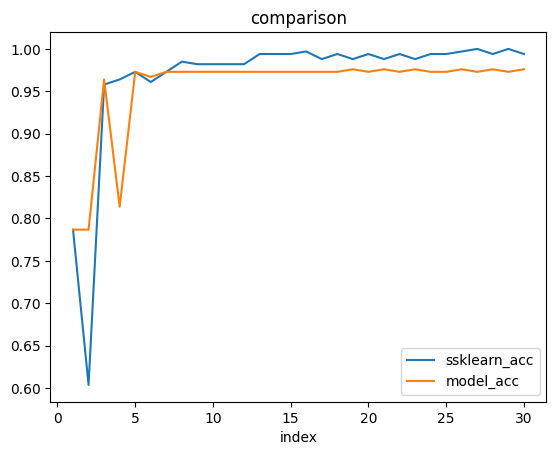

In [80]:
X = penguin_dataset[penguin_dataset.columns[:-1]].to_numpy()
y = penguin_dataset["species"]

indexes = []
sklearn_acc = []
model_acc = []
for index in range(1,31):
    indexes.append(index)

    ab = AdaBoostClassifier(algorithm="SAMME", n_estimators=index).fit(X, y)
    sklearn_acc.append(ab.score(X,y))

    my_ab = adaboost(penguin_dataset, "species", index)
    model_acc.append(adaboost_score(my_ab, X, y))

# saved_model_acc = [0.7867867867867868, 0.7867867867867868, 0.963963963963964, 0.8138138138138138, 0.972972972972973, 0.9669669669669669, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976]
plt.plot(indexes, sklearn_acc, label = "ssklearn_acc")
plt.plot(indexes, model_acc, label = "model_acc")
plt.legend()
plt.title('comparison')
plt.xlabel('index')
plt.show()

In [84]:
saved_model_acc = [0.7867867867867868, 0.7867867867867868, 0.963963963963964, 0.8138138138138138, 0.972972972972973, 0.9669669669669669, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976]

[0.7867867867867868, 0.7867867867867868, 0.963963963963964, 0.8138138138138138, 0.972972972972973, 0.9669669669669669, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976, 0.972972972972973, 0.975975975975976]


# Exercise grading

| Section | Exercise | Points |
| --- | --- | --- |
| I |	1 | 	0.1 |
| I |	2 | 	0.1 |
| I |	3 | 	0.25 |
| I |	4 | 	0.25 |
| I |	5 | 	0.15 |
| I |	6 | 	0.65 |
| I |	7 | 	0.1 |
| I |	8 | 	0.25 |
| I |	9 | 	0.15 |
| I |	10 | 	0.1 |
| I |	11 | 	0.1 |
| I |	12 | 	0.1 |
| I |	13 | 	0.15 |
| I |	14 | 	0.65 |
| I |	15 | 	0.1 |
| I |	16 | 	0.2 |
| I |	17 | 	0.1 |
|II | 	1 | 	0.2 |
|II | 	2 | 	0.1 |
|II | 	3 | 	0.15 |
|II | 	4 | 	0.2 |
|II | 	5 | 	0.72 |
|II | 	6 | 	0.1 |
|II | 	7 | 	0.28 |
|II | 	8 | 	0.1 |
|II | 	9 | 	0.15 |
|III |  1 | 0.1 |
|III |  2 | 0.2 |
|III |  3 | 0.3 |
|III |  4 | 0.15 |
|III |  5 | 0.15 |
|III |  6 | 0.3 |
|III |  7 | 0.5 |
|III |  8 | 0.4 |
|III |  9 | 0.1 |
|III |  10 | 0.5 |
|III |  11 | 0.2 |
|III |  12 | 1.1 |
|III |  13 | 0.2 |
|III |  14 | 0.1 |
|III |  15 | 0.2 |
